А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

Описание колонок:  
experimentVariant – вариант эксперимента  
version – версия приложения  
purchase – факт покупки  

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [4]:
df.head(10)

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
5,6,1679091c5a880faf6fb5e6087eb1b2dc,1,v2.8.0,0
6,7,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
7,8,c9f0f895fb98ab9159f51fd0297e236d,1,v2.8.0,0
8,9,45c48cce2e2d7fbdea1afc51c7c6ad26,0,v2.8.0,0
9,10,d3d9446802a44259755d38e6d163e820,1,v2.8.0,0


In [5]:
df[df.experimentVariant==1]['purchase'].head(10)

0     0
2     0
3     0
4     0
5     0
7     0
9     0
10    0
12    0
13    0
Name: purchase, dtype: int64

In [6]:
df[df.experimentVariant==0]['purchase'].head(10)

1     0
6     0
8     0
11    0
16    0
17    0
18    0
19    0
21    0
24    0
Name: purchase, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

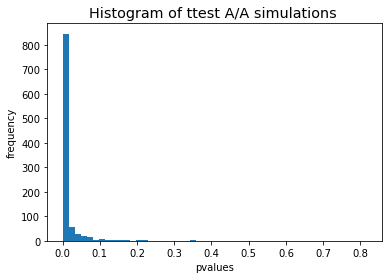

0.929

In [7]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR действительно оказался выше порогового значения. 

Изучим данные в срезах по версиям ПО

In [8]:
df.groupby(['experimentVariant', 'version'], as_index=False)\
        .agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Наибольшие вопросы вызывают результаты выборок с версией ПО v2.8.0. Проверим средние данных подвыборок т-тестом

In [9]:
v280zero = df.query('experimentVariant == 0 and version == "v2.8.0"').purchase
v280one = df.query('experimentVariant == 1 and version == "v2.8.0"').purchase

In [11]:
v280zero.mean()

0.0009931448780369644

In [12]:
v280one.mean()

0.04560550635348479

Разница между средними в группах огромна, проверим ее статзначимость

In [13]:
stats.ttest_ind(v280zero, v280one)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

Тест Стьюдента показал статзначимую разницу для данной версии ПО, попробуем не включать часть этих данных в A/A тест

In [14]:
df_corr = df.query('version != "v2.8.0"')

 Проверим результаты с откорректированными данными

  0%|          | 0/1000 [00:00<?, ?it/s]

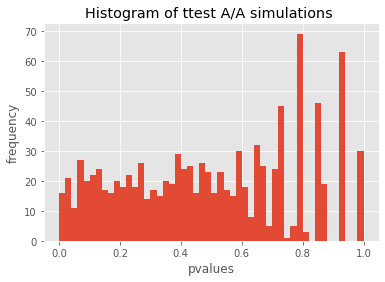

0.04

In [15]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_corr[df_corr.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    s2 = df_corr[df_corr.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест сошелся

Проблема лежит в области выборки в тестовую и контрольную группы в для версии приложения v2.8.0